# Run The Agent on Car Racing

In [23]:
import matplotlib.pyplot as plt
import tensorflow as tf
tf.config.run_functions_eagerly(True)

import gym
import numpy as np
import skimage as ski
import matplotlib.pyplot as plt

In [24]:
from conv_vae import ConvVAE, create_conv_encoder, create_conv_decoder
from transition_gru import TransitionGRU
from recurrent_agent import DAIFAgentRecurrent
from prior_model import PriorModelBellman

from train_agent import train_single_agent

In [25]:
from util import random_observation_sequence, transform_observations

In [26]:
from identity_vae import IdentityVAE, identity_encoder, identity_decoder

What does the agent do?
- The agent plans using a policy then executes that policy for 12 simulation timesteps, the first two actions of the policy are executed for 6 steps each

What data does it accumulate?
- It accumulates 12 observation actions pairs

How is it trained?
- VAE is trained to reproduce observations using the latent states
- Transition is trained by taking previous hidden state and previous latent state and trying to predict the next latent state


Online learning For all tasks, we initialize all the agents with random weights and learn online only. Training an agent for 150 epochs takes about 3 minutes on a single CPU core (Intel I7-4870HQ). In contrast, previous approaches using active inference [Ueltzhöffer, 2018, Tschantz et al., 2019, 2020] and policy gradient methods (e.g., [Liu et al., 2017]) use (offline) policy replay and typically need hours of GPU-accelerated compute while achieving similar convergence. To our knowledge, this is the first model-based RL method to learn online using neural network representations. This is afforded by the high sample efficiency of the FEEF, which directs exploration towards states that are uncertain for both the encoder and transition models.


Why this is true?

In [27]:
# Hide GPU from visible devices
# tf.config.set_visible_devices([], 'GPU')

## Test with no prior model FEEF

In [155]:
import tensorflow as tf
import tensorflow_probability as tfp
import keras
from keras import layers
import numpy as np


class Sampling(layers.Layer):
    """Uses (z_mean, z_stddev) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_stddev = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))

        return z_mean + z_stddev * epsilon


def create_conv_encoder(input_dim, latent_dim, conv_shapes=[3, 3, 3], num_filters=[32, 64, 64], dense_units=[16]):

    encoder_inputs = keras.Input(shape=input_dim)

    x = encoder_inputs
    for n in range(len(conv_shapes)):
        filter_shape = conv_shapes[n]
        num = num_filters[n]
        x = layers.Conv2D(num, filter_shape, activation="relu", strides=2, padding="same")(x)

    x = layers.Flatten()(x)

    for d in dense_units:
        x = layers.Dense(d, activation="relu")(x)

    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_std = layers.Dense(latent_dim, name="z_stddev")(x)  # output log of sd
    z_stddev = tf.exp(z_log_std)  # exponentiate to get sd
    z = Sampling()([z_mean, z_stddev])
    encoder = keras.Model(encoder_inputs, [z_mean, z_stddev, z], name="encoder")

    return encoder


def create_conv_decoder(latent_dim, output_shape, deconv_shapes=[3, 3, 3], num_filters=[64, 64, 32], dense_units=[16], rgb=True):

    latent_inputs = keras.Input(shape=(latent_dim,))

    x = latent_inputs

    for d in dense_units:
        x = layers.Dense(d, activation="relu")(x)

    first_shape = (deconv_shapes[0], deconv_shapes[0], num_filters[0])
    x = layers.Reshape(first_shape)(x)

    for n in range(len(deconv_shapes)):
        filter_shape = deconv_shapes[n]
        num = num_filters[n]
        x = layers.Conv2DTranspose(num, filter_shape, activation="relu", strides=2, padding="same")(x)

    if rgb:
        decoder_outputs = x
    else:
        decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)

    decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

    return decoder


class ConvVAE(keras.Model):
    def __init__(self, encoder, decoder, latent_dim, reg_mean, reg_stddev, recon_stddev=0.05, llik_scaling=1, kl_scaling=1, **kwargs):
        super(ConvVAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

        self.latent_dim = latent_dim

        self.reg_mean = reg_mean
        self.reg_stddev = reg_stddev

        self.reconstruction_stddev = recon_stddev

        self.llik_scaling = llik_scaling
        self.kl_scaling = kl_scaling

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def call(self, inputs, training=None, mask=None):
        _, _, z = self.encoder(inputs)
        reconstruction = self.decoder(z)
        return reconstruction


    def train_step(self, data):

        # unpack data
        # x, reg_vals = data
        x = data
        # reg_mean, reg_stddev = reg_vals
        with tf.GradientTape() as tape:
            z_mean, z_stddev, z = self.encoder(x)
            reconstruction = self.decoder(z)

            # TODO Fix this to be a real loss function
            reconstruction_loss = nll_gaussian(reconstruction, x, self.reconstruction_stddev, use_consts=False)

            posterior_dist = tfp.distributions.MultivariateNormalDiag(loc=z_mean, scale_diag=z_stddev)
            reg_dist = tfp.distributions.MultivariateNormalDiag(loc=self.reg_mean, scale_diag=self.reg_stddev)
            kl_loss = tfp.distributions.kl_divergence(posterior_dist, reg_dist) * self.kl_scaling

            # kl_loss = tf.reduce_sum(kl_loss, axis=1)
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),  # TODO should this be total_loss not loss
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


def nll_gaussian(pred, target, variance, use_consts=True):

    neg_log_prob = ((pred - target)**2/(2*variance))

    if use_consts:
        const = 0.5*np.log(2*np.pi*variance)
        neg_log_prob += const

    return tf.reduce_sum(neg_log_prob)


In [136]:
env = gym.make("CarRacing-v2", new_step_api=True)

env.reset()
action = env.action_space.sample()
env.step(action)

(array([[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        ...,
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]]], dtype=uint8),
 5.680346820809249,
 False,
 False,
 {})

In [94]:
import numpy as np

def random_observation_sequence(env, length, epsilon=0.5):

    observation = env.reset()

    observations = [observation]
    actions = []
    rewards = []

    action = env.action_space.sample()

    for _ in range(length):

        # change action with epsilon change action, else repeat the same action
        if np.random.uniform(0, 1) < epsilon:
            action = env.action_space.sample()

        observation, reward, done, *rest = env.step(action)

        actions.append(action)
        observations.append(observation)
        rewards.append(reward)

        # pad the end
        if done:
            break


    return np.array(observations), np.array(actions), np.array(rewards)


def transform_observations(observations, observation_max, observation_min, noise_stddev):
    """
    Transform mountain car observations to be in the range 0 to 1
    :param observations:
    :return:
    """

    # https://www.gymlibrary.ml/environments/classic_control/mountain_car_continuous/
    # the standard max and min values
    # observation_max = np.array([0.6, 0.07])
    # observation_min = np.array([-1.2, -0.07])

    # Need to increase the max and min to allow for random noise to be added
    # observation_max = np.array([1.2, 0.14])
    # observation_min = np.array([-2.4, -0.14])

    observations_scaled = (observations - observation_min)/(observation_max - observation_min)

    observations_scaled = 2*observations_scaled - 1

    # add noise
    observation_noisy = observations_scaled + np.random.normal(loc=0, scale=noise_stddev, size=observations_scaled.shape)

    observations_clipped = np.clip(observation_noisy, -1, 1)

    return observations_clipped

In [120]:
num_seqs = 20
seq_length = 2000
ob_dim = 2
ob_seqs = []
next_obs = []
observations = []

env = gym.make("CarRacing-v2", new_step_api=True)

observation_max = np.ones((96))

for i in range(num_seqs):
    o, a, r = random_observation_sequence(env, seq_length, epsilon=0.1)

    # o = transform_observations(o, observation_max, observation_min, observation_noise_stddev)

    # train = np.concatenate([o[:-1], a], axis=1)
    # train = o[:-1]
    # test = o[-1]

    observations.append(o)
    # ob_seqs.append(train)
    # next_obs.append(test)

observations = np.vstack(observations)
# observations = observations/255


x_min = 12
x_max = 84
y_min = 12
y_max = 84

observations = observations[:, x_min:x_max, y_min:y_max, :]

observations.shape

(40020, 72, 72, 3)

In [151]:
observations_scaled = ski.transform.resize(observations, (observations.shape[0], 64, 64, 3))

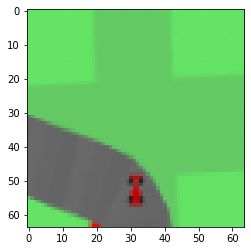

In [152]:
plt.imshow(observations_scaled[900], cmap="gray")

In [161]:
latent_dim = 32
e = create_conv_encoder(input_dim=(64, 64, 3), latent_dim=latent_dim, num_filters=[16, 32, 32], dense_units=[32])
e.summary()
d = create_conv_decoder(latent_dim=latent_dim, output_shape=(64, 64, 3), deconv_shapes=[8, 16, 32], num_filters=[16, 16, 3], dense_units=[8 * 8 * 16])
d.summary()
cvae = ConvVAE(e, d, latent_dim=latent_dim, reg_mean=[0] * latent_dim, reg_stddev=[1] * latent_dim)
cvae.compile(optimizer=tf.keras.optimizers.Adam())

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_44 (InputLayer)          [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d_66 (Conv2D)             (None, 32, 32, 16)   448         ['input_44[0][0]']               
                                                                                                  
 conv2d_67 (Conv2D)             (None, 16, 16, 32)   4640        ['conv2d_66[0][0]']              
                                                                                                  
 conv2d_68 (Conv2D)             (None, 8, 8, 32)     9248        ['conv2d_67[0][0]']              
                                                                                            

In [163]:
cvae.fit(observations_scaled, epochs=5, batch_size=64)

Epoch 1/5
626/626 [==============================] - 44s 71ms/step - loss: 7217.7020 - reconstruction_loss: 6852.2725 - kl_loss: 164.6676
Epoch 2/5
626/626 [==============================] - 44s 71ms/step - loss: 6755.3426 - reconstruction_loss: 6400.2744 - kl_loss: 157.6488
Epoch 3/5
626/626 [==============================] - 44s 71ms/step - loss: 6165.7882 - reconstruction_loss: 6006.8389 - kl_loss: 152.2671
Epoch 4/5
626/626 [==============================] - 45s 72ms/step - loss: 6188.2274 - reconstruction_loss: 5805.0474 - kl_loss: 146.0637
Epoch 5/5
626/626 [==============================] - 44s 71ms/step - loss: 5882.8734 - reconstruction_loss: 5475.0366 - kl_loss: 143.1380


In [164]:
res = cvae(observations_scaled[0:1000])
res

<tf.Tensor: shape=(1000, 64, 64, 3), dtype=float32, numpy=
array([[[[0.10163755, 0.08710617, 0.10615166],
         [0.10822736, 0.07152979, 0.10790016],
         [0.10393709, 0.06270713, 0.104606  ],
         ...,
         [0.05655741, 0.06449572, 0.06849591],
         [0.05679156, 0.05912433, 0.06614723],
         [0.05918418, 0.05878132, 0.07126828]],

        [[0.10353954, 0.08694787, 0.10721067],
         [0.10626154, 0.06507824, 0.10672563],
         [0.09768938, 0.05649228, 0.10567817],
         ...,
         [0.05611872, 0.06658863, 0.06970102],
         [0.05609376, 0.06390461, 0.06934007],
         [0.05638633, 0.05809105, 0.07250793]],

        [[0.10608158, 0.08743504, 0.10519463],
         [0.10458615, 0.06081173, 0.10273746],
         [0.09905308, 0.05153751, 0.10254117],
         ...,
         [0.05433555, 0.06802258, 0.06722931],
         [0.05419179, 0.06418359, 0.06781083],
         [0.05743573, 0.05584339, 0.07200748]],

        ...,

        [[0.4048331 , 0.7782724 ,

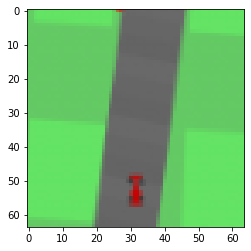

In [167]:
plt.imshow(observations_scaled[200], cmap="gray")

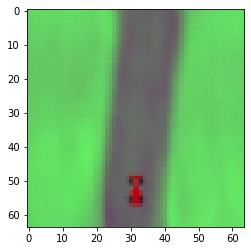

In [169]:
plt.imshow(res[200], cmap="gray")

## Test with the prior model FEEF

In [ ]:
enc = create_encoder(2, 2, [20])
dec = create_decoder(2, 2, [20])
vae = VAE(enc, dec, [0, 0], [0.3, 0.3], llik_scaling=1, recon_stddev=0.05)

pl_hoz = 5
latent_dim = 2

tran = TransitionGRU(2, 1, 12, 2*latent_dim*pl_hoz, 2)

# unscaled prior mean and prior stddev
prior_model = PriorModelBellman(2)

observation_max = np.array([0.6, 0.07])
observation_min = np.array([-1.2, -0.07])

# observation_noise_stddev = [0, 0]
observation_noise_stddev = [0.05, 0.05]

daifa = DAIFAgentRecurrent(prior_model,
                           vae,
                           tran,
                           None,
                           None,
                           train_prior_model=True,
                           planning_horizon=pl_hoz,
                           use_kl_extrinsic=True,
                           use_kl_intrinsic=True,
                           use_FEEF=True,
                           vae_train_epochs=1,
                           tran_train_epochs=1,
                           show_vae_training=False)

In [ ]:
# train the agent on the env
env = gym.make('MountainCarContinuous-v0')
agent, results = train_agent(env, daifa, observation_max, observation_min, observation_noise_stddev, num_episodes=40, action_repeats=6, num_actions_to_execute=5, train_on_full_data=True)

## Test the models produced

In [ ]:
num_seqs = 20
seq_length = 300
ob_dim = 2
ob_seqs = []
next_obs = []
observations = []

env = gym.make('MountainCarContinuous-v0')

for i in range(num_seqs):
    o, a, r = random_observation_sequence(env, 1000, epsilon=0.1)

    o = transform_observations(o, observation_max, observation_min, observation_noise_stddev)

    train = np.concatenate([o[:-1], a], axis=1)
    # train = o[:-1]
    test = o[-1]

    observations.append(o)
    ob_seqs.append(train)
    next_obs.append(test)

# ob_seqs = np.array(ob_seqs)
# next_obs = np.array(next_obs)

observations = np.vstack(observations)
# observations = observations.reshape((num_seqs*(seq_length+1), ob_dim))

# ob_seqs_stddev = np.ones_like(ob_seqs_flat)
# next_obs_stddev = np.ones_like(ob_seqs_flat)

observations.shape

In [ ]:
observations

In [ ]:
agent.model_vae(observations)

In [ ]:
## Test the models produced
num_seqs = 20
seq_length = 300
ob_dim = 2
ob_seqs = []
next_obs = []
observations = []

env = gym.make('MountainCarContinuous-v0')

for i in range(num_seqs):
    o, a, r = random_observation_sequence(env, 1000, epsilon=0.1)

    o = transform_observations(o, observation_max, observation_min, observation_noise_stddev)

    train = np.concatenate([o[:-1], a], axis=1)
    # train = o[:-1]
    test = o[-1]

    observations.append(o)
    ob_seqs.append(train)
    next_obs.append(test)

# ob_seqs = np.array(ob_seqs)
# next_obs = np.array(next_obs)

observations = np.vstack(observations)
# observations = observations.reshape((num_seqs*(seq_length+1), ob_dim))

# ob_seqs_stddev = np.ones_like(ob_seqs_flat)
# next_obs_stddev = np.ones_like(ob_seqs_flat)

observations.shape
observations
agent.model_vae(observations)
## Test EFE

## Test EFE

In [ ]:
enc = create_encoder(2, 2, [20])
dec = create_decoder(2, 2, [20])
vae = VAE(enc, dec, [0, 0], [0.3, 0.3], llik_scaling=1)

pl_hoz = 5
latent_dim = 2

tran = TransitionGRU(2, 1, 12, 2*pl_hoz*latent_dim, 2)

# unscaled prior mean and prior stddev
prior_mean = [0.45, 0]
prior_stddev = [1, 1]

# unscaled prior mean and prior stddev
prior_model = PriorModelBellman(2)

observation_max = np.array([0.6, 0.07])
observation_min = np.array([-1.2, -0.07])

observation_noise_stddev = [0, 0]

scaled_prior_mean = transform_observations(prior_mean, observation_max, observation_min, [0,0])  # no noise on prior

# without prior model
daifa = DAIFAgentRecurrent(None,
                           vae,
                           tran,
                           scaled_prior_mean,
                           prior_stddev,
                           planning_horizon=pl_hoz,
                           use_kl_extrinsic=True,
                           use_kl_intrinsic=True,
                           use_FEEF=False,
                           vae_train_epochs=1,
                           tran_train_epochs=1,
                           show_vae_training=False)

# with prior model
daifa = DAIFAgentRecurrent(prior_model,
                           vae,
                           tran,
                           None,
                           None,
                           planning_horizon=pl_hoz,
                           use_kl_extrinsic=True,
                           use_kl_intrinsic=True,
                           use_FEEF=False,
                           vae_train_epochs=1,
                           tran_train_epochs=1,
                           show_vae_training=False)

scaled_prior_mean

In [ ]:
# train the agent on the env
env = gym.make('MountainCarContinuous-v0')
agent, results = train_agent(env, daifa, observation_max, observation_min, observation_noise_stddev, num_episodes=20, action_repeats=10, num_actions_to_execute=2, train_on_full_data=True)

In [ ]:
## Test the models produced
num_seqs = 20
seq_length = 300
ob_dim = 2
ob_seqs = []
next_obs = []
observations = []

env = gym.make('MountainCarContinuous-v0')

for i in range(num_seqs):
    o, a, r = random_observation_sequence(env, 1000, epsilon=0.1)

    o = transform_observations(o, observation_max, observation_min, observation_noise_stddev)

    train = np.concatenate([o[:-1], a], axis=1)
    # train = o[:-1]
    test = o[-1]

    observations.append(o)
    ob_seqs.append(train)
    next_obs.append(test)

# ob_seqs = np.array(ob_seqs)
# next_obs = np.array(next_obs)

observations = np.vstack(observations)
# observations = observations.reshape((num_seqs*(seq_length+1), ob_dim))

# ob_seqs_stddev = np.ones_like(ob_seqs_flat)
# next_obs_stddev = np.ones_like(ob_seqs_flat)

observations.shape

In [ ]:
observations

In [ ]:
agent.model_vae(observations)
## Test EFE

## Testing the Identity VAE

In [ ]:
enc = identity_encoder
dec = identity_decoder
idvae = IdentityVAE(enc, dec, [0, 0], [0.3, 0.3], llik_scaling=100)

hidden_size = 2*2*15  # 2*latent_dim * planning_size
tran = TransitionGRU(2, 1, 12, hidden_size, 2)

# unscaled prior mean and prior stddev
prior_mean = [0.6, 0]
prior_stddev = [1, 1]

observation_max = np.array([0.6, 0.07])
observation_min = np.array([-1.2, -0.07])

observation_noise_stddev = [0, 0]

scaled_prior_mean = transform_observations(prior_mean, observation_max, observation_min, [0,0])  # no noise on prior

daifa = DAIFAgentRecurrent(None, idvae, tran, scaled_prior_mean, prior_stddev)

In [ ]:
env = gym.make('MountainCarContinuous-v0')

agent, succeeded, time_to_success = train_agent(env, daifa, observation_max, observation_min, observation_noise_stddev, num_episodes=5)

In [ ]:
out = agent.tran((ob_seqs[0:1], None))
out

In [ ]:
t = ob_seqs[0:1, -1].reshape(1,1,3)
h = out[3]
h = h[0, -2, :]
h = h.numpy().reshape(1,30)
h

In [ ]:
agent.tran((t, h))

In [ ]:
ob_seqs[0:1]

## Test to see how the agent trains on standard observation data

In [ ]:
enc = identity_encoder
dec = identity_decoder
idvae = IdentityVAE(enc, dec, [0, 0], [0.3, 0.3], llik_scaling=100)

hidden_size = 2*2*15  # 2*latent_dim * planning_size
tran = TransitionGRU(2, 1, 12, hidden_size, 2)

# unscaled prior mean and prior stddev
prior_mean = [0.45, 0]
prior_stddev = [1, 1]

observation_max = np.array([0.6, 0.07])
observation_min = np.array([-1.2, -0.07])

observation_noise_stddev = [0, 0]

scaled_prior_mean = transform_observations(prior_mean, observation_max, observation_min, [0,0])  # no noise on prior

daifa = DAIFAgentRecurrent(None, idvae, tran, scaled_prior_mean, prior_stddev, vae_train_epochs=1, tran_train_epochs=2)

In [ ]:
env = gym.make('MountainCarContinuous-v0')
success, agent, t, pre_obs, post_obs, acts = run_episode(env, daifa, observation_max, observation_min, observation_noise_stddev)

In [ ]:
pre_np = np.array(pre_obs)
a = np.array(acts)
a.shape
pre_a = np.concatenate([pre_np, a], axis=2)

In [ ]:
print(a.max(), a.min())

In [ ]:
pre_a

In [ ]:
post_obs_to_predict = np.array(post_obs)[:, 14, :]
post_obs_to_predict

In [ ]:
agent.tran((pre_a, None))

In [ ]:
post_obs_to_predict

## Examine training the model on the observation data

Does it eventually converge to a good model

In [ ]:
num_train_runs = 1
for i in range(num_train_runs):

    for j in range(len(pre)):
        pre = pre_obs[j]
        post = post_obs[j]
        actions = acts[j]

        daifa.train(pre, post, actions, None, verbose=1)

In [ ]:
daifa.cem_policy_optimisation(np.array([0.5, 0.1]))

In [ ]:
daifa.cem_policy_optimisation

## Test the FEEF computations

In [ ]:
# enc = create_encoder(2, 2, [20])
# dec = create_decoder(2, 2, [20])
# vae = VAE(enc, dec, [0, 0], [0.3, 0.3], llik_scaling=100)

enc = identity_encoder
dec = identity_decoder
idvae = IdentityVAE(enc, dec, [0, 0], [0.3, 0.3], llik_scaling=100)

tran = TransitionGRU(2, 1, 12, 60, 2)

# unscaled prior mean and prior stddev
prior_mean = [0.6, 0]
prior_stddev = [1, 1]

observation_max = np.array([0.6, 0.07])
observation_min = np.array([-1.2, -0.07])

observation_noise_stddev = [0, 0]

scaled_prior_mean = transform_observations(prior_mean, observation_max, observation_min, [0, 0])  # no noise on prior

print(scaled_prior_mean)

daifa = DAIFAgentRecurrent(None, idvae, tran, scaled_prior_mean, prior_stddev, planning_horizon=15, n_policy_candidates=70, n_policies=1500, n_cem_policy_iterations=5)

In [ ]:
env = gym.make('MountainCarContinuous-v0')

agent, succeeded, time_to_success = train_agent(env, daifa, observation_max, observation_min, observation_noise_stddev,
                                                num_episodes=1)

In [ ]:
def test_policy(agent, env, policy, action_repeats):

    observation = env.reset()
    obs = transform_observations(observation, observation_max, observation_min, [0, 0])

    z_t_minus_1 = obs
    p, s = agent.cem_policy_optimisation(z_t_minus_1)
    p
    print(obs)
    print(p)

    for action in p:
        for t in range(action_repeats):
            res = env.step(np.array([action]))
            print(res)

In [ ]:
z_t_minus_1 = np.array([0, 0])
p, s = agent.cem_policy_optimisation(z_t_minus_1)
p

agent.forward_policies(p, z_t_minus_1)

In [ ]:
env = gym.make('MountainCarContinuous-v0')

test_policy(agent, env, p.numpy(), 6)

In [ ]:
z_t_minus_1 = np.array([-0.27691475,  0.01688306])
p, s = agent.cem_policy_optimisation(z_t_minus_1)
p

In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np

from vae_recurrent import VAE


class DAIFAgentRecurrent:

    def __init__(self,
                 prior_model,
                 vae,
                 tran,
                 given_prior_mean,
                 given_prior_stddev,
                 planning_horizon=15,
                 n_policies=1500,
                 n_cem_policy_iterations=2,
                 n_policy_candidates=70,
                 tran_train_epochs=1,
                 vae_train_epochs=1,
                 agent_time_ratio=6,
                 train_vae=True,
                 train_tran=True):

        super(DAIFAgentRecurrent, self).__init__()

        self.prior_model = prior_model
        self.planning_horizon = planning_horizon
        self.n_policy_candidates = n_policy_candidates
        self.n_policies = n_policies
        self.n_cem_policy_iterations = n_cem_policy_iterations

        self.vae_train_epochs = vae_train_epochs
        self.tran_train_epochs = tran_train_epochs
        self.train_vae = train_vae
        self.train_tran = train_tran

        self.given_prior_mean = given_prior_mean
        self.given_prior_stddev = given_prior_stddev

        # full vae
        self.model_vae = vae
        self.model_vae.compile(optimizer=tf.keras.optimizers.Adam())

        # transition
        # takes action plus last state and outputs next latent state
        self.tran = tran
        self.tran.compile(optimizer=tf.keras.optimizers.Adam())

        self.hidden_state = None

        # how much is the agents planning time compressed compared to the simulation time
        self.agent_time_ratio = agent_time_ratio


    def select_policy(self, observation):

        policy_mean, policy_stddev = self.cem_policy_optimisation(observation)

        # return a distribution that we can sample from
        return tfp.distributions.MultivariateNormalDiag(loc=policy_mean, scale_diag=policy_stddev)


    def train(self, pre_observations_raw, post_observations_raw, actions_complete, rewards, verbose=0):

        # compress the observations based on the agents time compression factor
        # pre_observations = pre_observations_raw[::self.agent_time_ratio]  # for example take every 6th element
        # post_observations = np.array([post_observations_raw[i] for i in range(len(post_observations_raw)) if i % self.agent_time_ratio == self.agent_time_ratio - 1])
        #
        # print(pre_observations_raw)
        # print(pre_observations)
        # print(post_observations_raw)
        # print(post_observations)

        pre_observations = pre_observations_raw
        post_observations = post_observations_raw

        # only look at the first n actions that we took
        actions = actions_complete[0: len(pre_observations)]

        num_observations = pre_observations.shape[0]
        observation_dim = pre_observations.shape[1]
        action_dim = actions.shape[1]
        # action_dim = 1  # TODO fix this to allow different actions

        # find the actual observed latent states using the vae
        pre_latent_mean, pre_latent_stddev, pre_latent = self.model_vae.encoder(pre_observations)
        post_latent_mean, post_latent_stddev, post_latent = self.model_vae.encoder(post_observations)

        # set up the input training data that we use to train the transition model
        z_train = np.concatenate([np.array(pre_latent_mean), np.array(actions)], axis=1)

        # we use the sequence to find the right hidden states to use as input
        z_train_seq = z_train.reshape((1, num_observations, observation_dim + action_dim))
        z_train_singles = z_train.reshape(num_observations, 1, observation_dim + action_dim)

        # the previous hidden state is the memory after observing some sequences but it might be None
        if self.hidden_state is None:
            self.hidden_state = np.zeros((1, self.tran.hidden_units))

        if self.train_tran:
            # find the hidden states at t=0, t=1, t=2, ..., t=num_observations - 1
            _, _, _, h_states = self.tran((z_train_seq, self.hidden_state))


            # squeeze so we make the shape [num_observations, hidden_units]
            h_states = tf.squeeze(h_states)

            # exclude the last state as this will become the hidden state later on. next hidden state will become our new memory
            h_states_for_training = h_states[:-1]
            # next_hidden_state = h_states[-1]

            # add the current hidden state we saved to the start. This has h0, h1, h2, .. h=num_observations - 1
            h_states_for_training = tf.concat([self.hidden_state, h_states_for_training], axis=0)


            # use the hidden states with the pre and post observations to train transition model
            self.tran.fit((z_train_singles, h_states_for_training), (post_latent_mean, post_latent_stddev), epochs=self.tran_train_epochs, verbose=verbose)

        # now find the new predicted hidden state that we will use for finding the policy
        # TODO not sure if I should pass the old hidden state or reset it to 0
        _, _, final_hidden_state, _ = self.tran((z_train_seq, self.hidden_state))
        # _, _, final_hidden_state, _ = self.tran((z_train_seq, None))

        self.hidden_state = final_hidden_state

        #### TRAIN THE VAE ####
        if self.train_vae:
            # train the vae model on post_observations because these are all new
            self.model_vae.fit(post_observations, epochs=self.vae_train_epochs, verbose=verbose)



    def cem_policy_optimisation(self, z_t_minus_one):

        # need to change these two if the policy dimension changes
        mean_best_policies = tf.zeros(self.planning_horizon)
        std_best_policies = tf.ones(self.planning_horizon)

        for i in range(self.n_cem_policy_iterations):
            policy_distr = tfp.distributions.MultivariateNormalDiag(loc=mean_best_policies, scale_diag=std_best_policies)
            policies = policy_distr.sample([self.n_policies])
            policies = tf.clip_by_value(policies, clip_value_min=-1, clip_value_max=1)

            # project trajectory into the future using transition model and calculate FEEF for each policy
            policy_results = self.forward_policies(policies.numpy(), z_t_minus_one)
            FEEFs = self.evaluate_policy(*policy_results)

            FEEFs = tf.convert_to_tensor(FEEFs)

            # sum over the timesteps to get the FEEF for each policy
            FEEFs_sum = tf.reduce_sum(FEEFs, axis=0)

            # multiply by one to find largest value which is euqivalent to smallest FEEF with top_k
            neg_FEEF_sum = -1*FEEFs_sum

            result = tf.math.top_k(neg_FEEF_sum, self.n_policy_candidates, sorted=False)
            min_FEEF_indices = result.indices

            # update the policy distributions
            mean_best_policies = tf.reduce_mean(tf.gather(policies, min_FEEF_indices), axis=0)
            std_best_policies = tf.math.reduce_std(tf.gather(policies, min_FEEF_indices), axis=0)


        # TODO not sure why we need all of this is with the x means? I think it's for training but maybe not

        # One last forward pass to gather the stats of the policy mean
        #FEEFs, next_x_means, next_x_stds = self._forward_policies(mean_best_policies.unsqueeze(1))
        # return mean_best_policies, std_best_policies, FEEFs.detach().squeeze(1), next_x_means.detach().squeeze(1), next_x_stds.detach().squeeze(1)

        print(z_t_minus_one)
        print(mean_best_policies)
        return mean_best_policies, std_best_policies


    def forward_policies(self, policies, z_t_minus_one):
        """
        Forward propogate a policy and compute the FEEF of each policy
        :param z_t_minus_one:
        :return:
        """

        # stack up the new observation to have shape [self.n_policies, len(z_t_minus_one)]
        prev_latent_mean = np.stack([z_t_minus_one]*self.n_policies)

        policy_posteriors = []
        policy_sds = []
        likelihoods = []
        z_means = []
        z_sds = []

        # get the starting hidden state that coressponds to the memory stored by the previous sequences. Should have shape (1, self.tran.num_hidden_units) for the observed sequence
        # extend the current hidden state to the number of policies present
        if self.hidden_state is None:
            cur_hidden_state = np.zeros((self.n_policies, self.tran.hidden_units))
        else:
            cur_hidden_state = np.vstack([self.hidden_state]*self.n_policies)

        # print(cur_hidden_state)

        # find the predicted latent states from the transition model
        for t in range(self.planning_horizon):

            ob_plus_action = np.concatenate([prev_latent_mean, policies[:, t].reshape(self.n_policies, 1)], axis=1)
            tran_input = ob_plus_action.reshape((self.n_policies, 1, ob_plus_action.shape[1]))  # reshape to pass to GRU

            next_latent_mean, next_latent_sd, next_hidden_state, _ = self.tran((tran_input, cur_hidden_state))  # shape = [num policies, latent dim

            # update the hidden state for use with the next policies
            cur_hidden_state = next_hidden_state

            policy_posteriors.append(next_latent_mean)
            policy_sds.append(next_latent_sd)

            next_likelihoods = self.model_vae.decoder(next_latent_mean)
            likelihoods.append(next_likelihoods)

            next_posterior_means, next_posteriors_sds, next_posteriors_z = self.model_vae.encoder(next_likelihoods)
            z_means.append(next_posterior_means)
            z_sds.append(next_posteriors_sds)

            prev_latent_mean = next_latent_mean

        return policy_posteriors, policy_sds, likelihoods, z_means, z_sds


    def evaluate_policy(self, policy_posteriors, policy_sd, predicted_likelihood, predicted_posterior, predicted_posterior_sd):

        return self.FEEF(policy_posteriors, policy_sd, predicted_likelihood, predicted_posterior, predicted_posterior_sd)


    def FEEF(self, policy_posteriors_list, policy_sd_list, predicted_likelihood_list, predicted_posterior_list, predicted_posterior_sd_list):
        """
        Compute the FEEF for policy selection
        :param policy_posteriors:
        :param predicted_likelihood:
        :param predicted_posterior:
        :return:
        """

        FEEFs = []

        for t in range(self.planning_horizon):

            # extract the values for each time step
            predicted_likelihood = predicted_likelihood_list[t]
            policy_posteriors = policy_posteriors_list[t]
            policy_sd = policy_sd_list[t]
            predicted_posterior = predicted_posterior_list[t]
            predicted_posterior_sd = predicted_posterior_sd_list[t]

            # !!!! evaluate the EXTRINSIC KL divergence !!!!

            # convert to normal distributions
            # TODO Why is the stddev 1s here? I think because we assume it is on the true state of the world.
            likelihood_dist = tfp.distributions.MultivariateNormalDiag(loc=predicted_likelihood, scale_diag=np.ones_like(predicted_likelihood))

            if self.prior_model is None:

                # TODO how exactly is the prior defined? After you apply transformations what is the prior
                # create the prior distribution
                prior_preferences_mean = tf.convert_to_tensor(np.stack([self.given_prior_mean]*self.n_policies), dtype="float32")
                prior_preferences_stddev = tf.convert_to_tensor(np.stack([self.given_prior_stddev]*self.n_policies), dtype="float32")

                prior_dist = tfp.distributions.MultivariateNormalDiag(loc=prior_preferences_mean, scale_diag=prior_preferences_stddev)

            # TODO Fix the learned prior model
            else:
                prior_dist = self.prior_model()

            kl_extrinsic = tfp.distributions.kl_divergence(likelihood_dist, prior_dist)

            # !!!! evaluate the KL INTRINSIC part !!!!
            policy_posteriors_dist = tfp.distributions.MultivariateNormalDiag(loc=policy_posteriors, scale_diag=policy_sd)
            predicted_posterior_dist = tfp.distributions.MultivariateNormalDiag(loc=predicted_posterior, scale_diag=predicted_posterior_sd)

            kl_intrinsic = tfp.distributions.kl_divergence(predicted_posterior_dist, policy_posteriors_dist)

            FEEF = kl_extrinsic - kl_intrinsic

            FEEFs.append(FEEF)

        return FEEFs


    def EFE(self, policy_posteriors, predicted_likelihood, predicted_posterior):
        """
        Compute the EFE for policy selection
        :param policy_posteriors:
        :param predicted_likelihood:
        :param predicted_posterior:
        :return:
        """
        pass

## Testing with a pretrained transition model

This works well! So the problem can't lie with the transition model.

In [ ]:
# enc = create_encoder(2, 2, [20])
# dec = create_decoder(2, 2, [20])
# vae = VAE(enc, dec, [0, 0], [0.3, 0.3], llik_scaling=100)

enc = identity_encoder
dec = identity_decoder
idvae = IdentityVAE(enc, dec, [0, 0], [0.3, 0.3], llik_scaling=100)

tran = TransitionGRU(2, 1, 12, 60, 2)

# unscaled prior mean and prior stddev
prior_mean = [0.6, 0.07]
prior_stddev = [1, 1]

observation_max = np.array([0.6, 0.07])
observation_min = np.array([-1.2, -0.07])

observation_noise_stddev = [0, 0]

scaled_prior_mean = transform_observations(prior_mean, observation_max, observation_min, [0, 0])  # no noise on prior

print(scaled_prior_mean)

daifa = DAIFAgentRecurrent(None, idvae, tran, scaled_prior_mean, prior_stddev, train_vae=False)

In [ ]:
num_seqs = 200
seq_length = 500
ob_seqs = []
next_obs = []
next_obs_stddev = []
actions = []

env = gym.make('MountainCarContinuous-v0')

for i in range(num_seqs):
    o, a, r = random_observation_sequence(env, seq_length, epsilon=0.2)

    o = transform_observations(o, observation_max, observation_min, [0, 0])

    # train = np.concatenate([o[:-1], a], axis=1)
    train = o[:-1]
    test = o[1:]

    actions.append(a)
    ob_seqs.append(train)
    next_obs.append(test)

    ob_seqs_stddev = np.ones_like(train)
    next_stddev = np.ones_like(test)

    next_obs_stddev.append(next_stddev)

In [ ]:
for i in range(num_seqs):

    pre = ob_seqs[i]
    next = next_obs[i]
    acts = actions[i]

    next_sd = next_obs_stddev[i]

    daifa.train(pre, next, acts, None, verbose=1)

In [ ]:
num_seqs = 20
seq_length = 150
ob_seqs = []
next_obs = []

for i in range(num_seqs):
    o, a, r = random_observation_sequence(env, seq_length, epsilon=0.1)

    o = transform_observations(o, observation_max, observation_min, [0, 0])

    train = np.concatenate([o[:-1], a], axis=1)
    test = o[-1]

    ob_seqs.append(train)
    next_obs.append(test)

ob_seqs = np.array(ob_seqs)[:, -5:, :]
next_obs = np.array(next_obs)
ob_seqs.shape

ob_seqs_stddev = np.ones_like(ob_seqs)
next_obs_stddev = np.ones_like(next_obs)

ob_seqs.shape

In [ ]:
daifa.tran((ob_seqs, None))

In [ ]:
next_obs

That looks fantastic!!! With enough data the transition model is training very well

In [ ]:
daifa.hidden_state

In [ ]:
z_t_minus_1 = np.array([0.4, 0.5])
daifa.hidden_state = None
p, s = daifa.cem_policy_optimisation(z_t_minus_1)
p

In [ ]:
daifa.tran((np.array([[[0.4, 0.5, 1]]]), None))

In [ ]:
env = gym.make('MountainCarContinuous-v0')

daifa.train_tran = False
daifa.train_vae = False

daifa.hidden_state = None

agent, succeeded, time_to_success = train_agent(env, daifa, observation_max, observation_min, observation_noise_stddev,
                                                num_episodes=1)